# ITBA 82.05 : Análisis Predictivo 

# Final exam

# Elsa DOYEN 65990

## Introduction


In this final project, we're going to take up all the elements of the course we've covered during the semester. To do this, we'll take the same case study as for the first part and apply the prediction models we've seen.

Our database is made up of 70692 individuals, a predictor variable "diabetes" and 21 other variables corresponding to the various physical and mental characteristics of the individuals (age, cholesterol, smoker, etc.). 

The variable to be explained "diabete" is a binary variable: 0 if the person doesn't have diabetes and 1 if they do. I chose to use the kaggle balanced database, i.e. in the database there are as many people with diabetes as without. Taking a balanced set of data means better performance. An unbalanced dataset can lead to model bias. The model may be biased in favor of over-represented classes, as it will tend to learn more features from these classes, to the detriment of under-represented classes.

The aim here is to present ourselves as an insurance company seeking to find out the probability of an individual developing diabetes. The aim of the project is therefore to predict the probability of a given individual developing diabetes. This can enable insurance companies to provide financial medical assistance.

In [1]:
# Package import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy.stats import chi2_contingency
import time
import xgboost as xgb


## Data download

In [2]:
data = pd.read_csv('diabetes_5050.csv')

In [3]:
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In this project, we will first carry out the cleaning and exploratory analysis of the database. The aim here is to see if certain variables are correlated with each other, or if certain variables need to be deleted for lack of data.

## Cleaning of the dataset

In this section, we're going to clean up the database so that we can work with it properly. To do this, we'll first check that there are as many people with diabetes as there are healthy people.

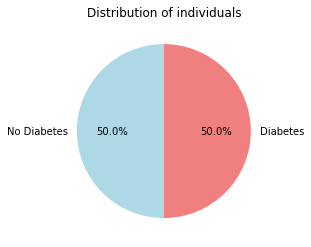

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64


In [4]:
freq_table = data['Diabetes_binary'].value_counts()

# Display number of each
labels = ['No Diabetes', 'Diabetes']
colors = ['lightblue', 'lightcoral']
plt.pie(freq_table, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of individuals")
plt.show()

# Display frequencies table
print(freq_table)

Next, we change the diabete variable into a binary variable. It was previously considered an integer.

In [5]:
data['diabete'] = data['Diabetes_binary']

# Delete column 'Diabetes_binary' 
data = data.drop(columns=['Diabetes_binary'])

# Convert 'diabete' column to type factor (category)
data['diabete'] = data['diabete'].astype('category')

Then we look for missing values in our database.

In [6]:
na_counts = data.isna().sum()
print(na_counts)

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
diabete                 0
dtype: int64


Finally, we don't need to rework the database as there are no missing values.

## Exploratory database analysis

As a first step, we will create a number of graphs showing for each categorical variable the percentage of sick people compare to the percentage of healthy people.

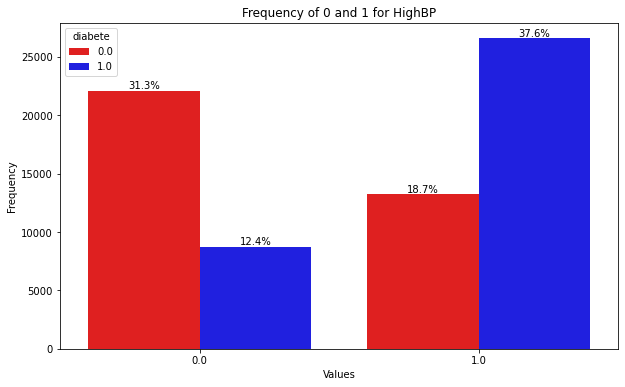

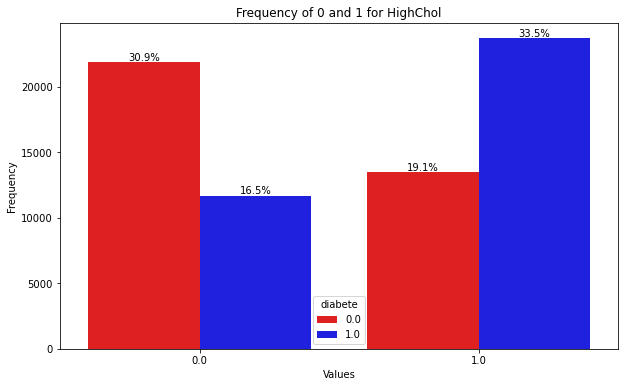

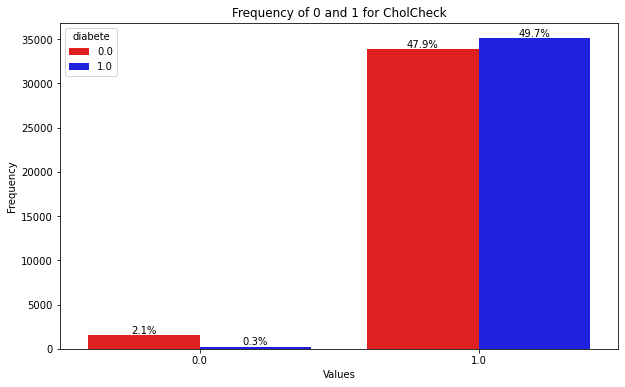

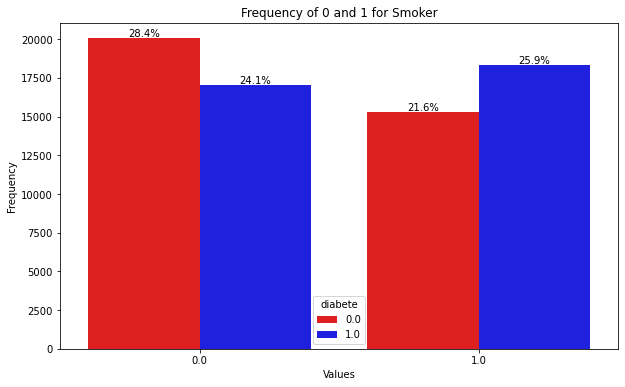

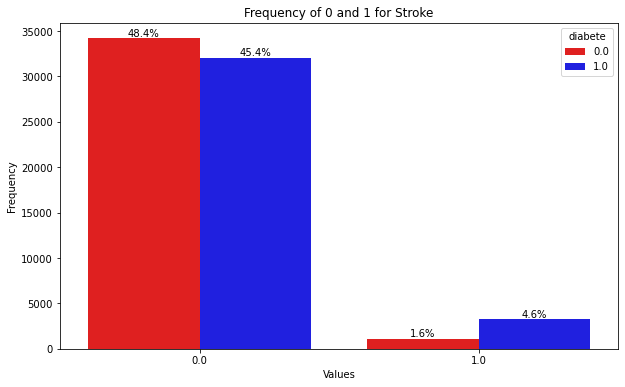

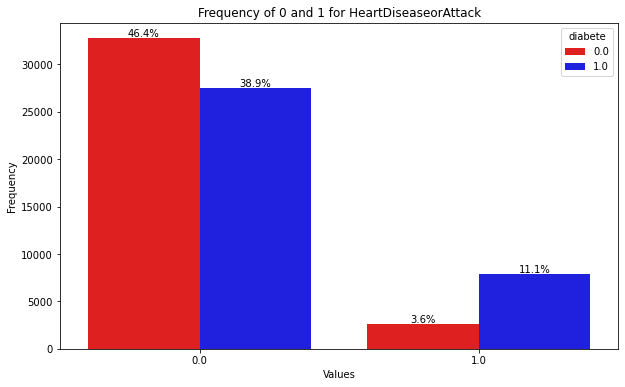

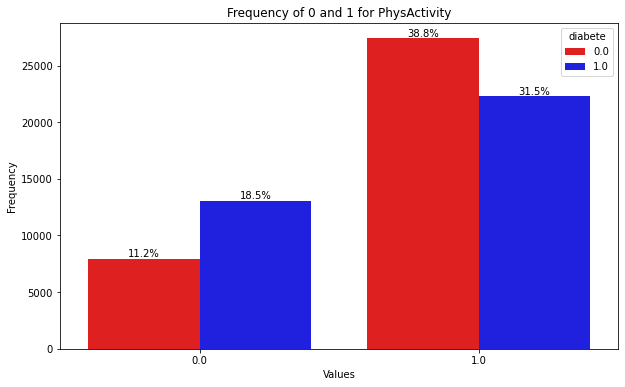

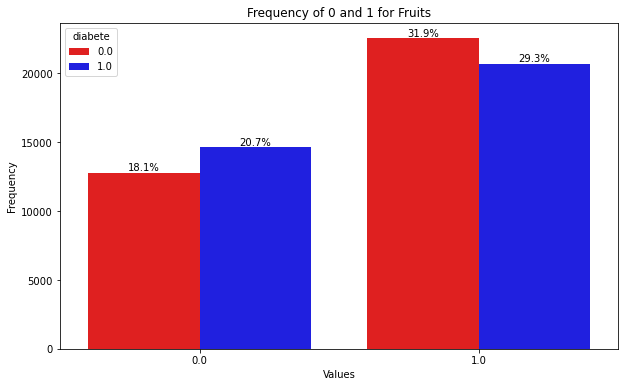

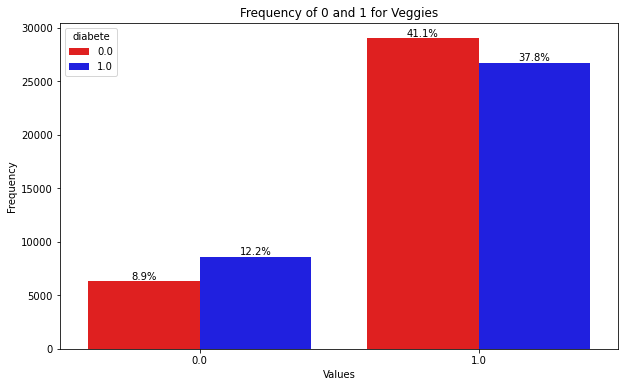

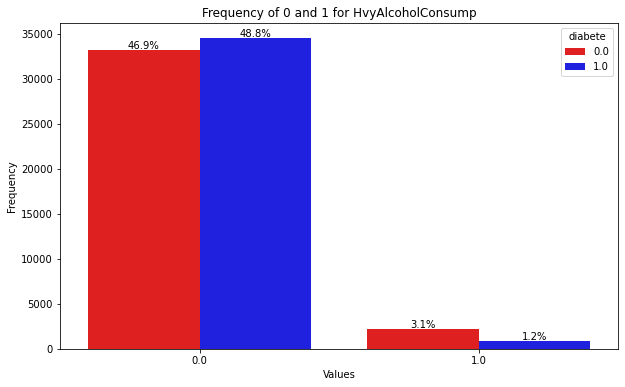

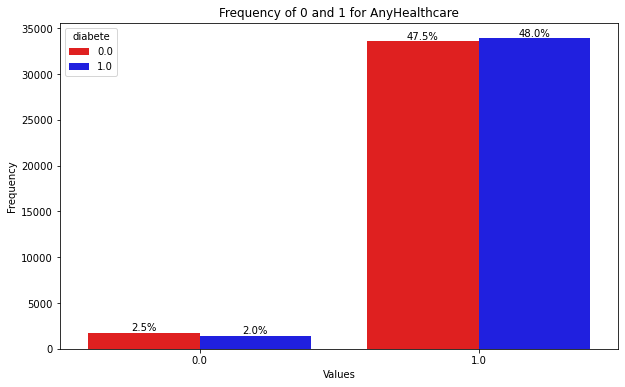

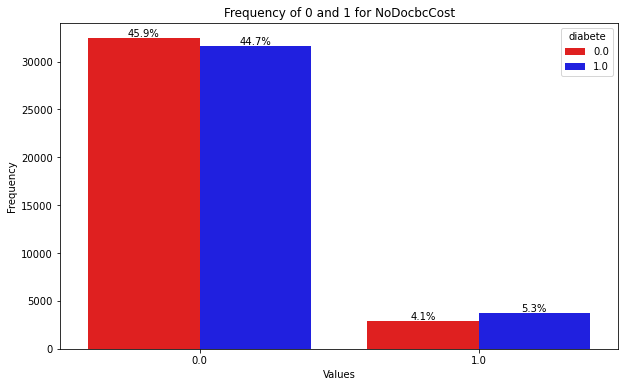

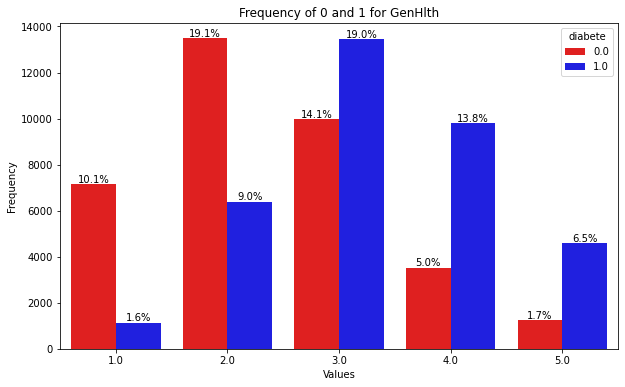

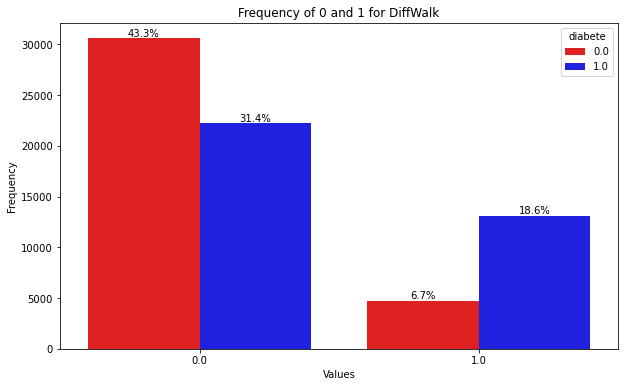

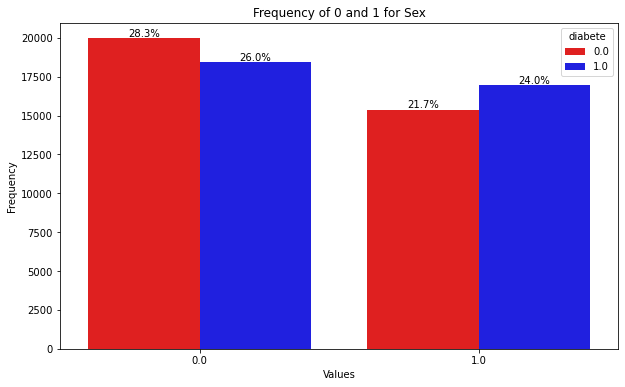

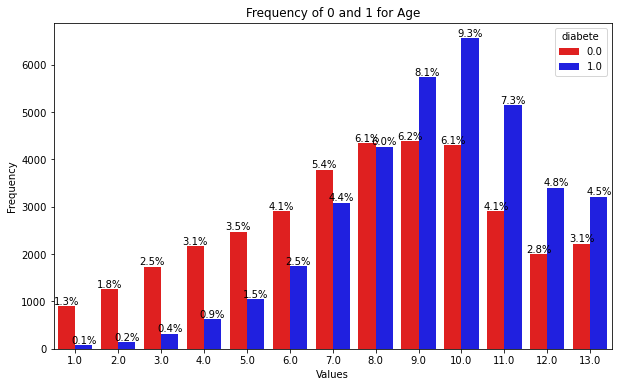

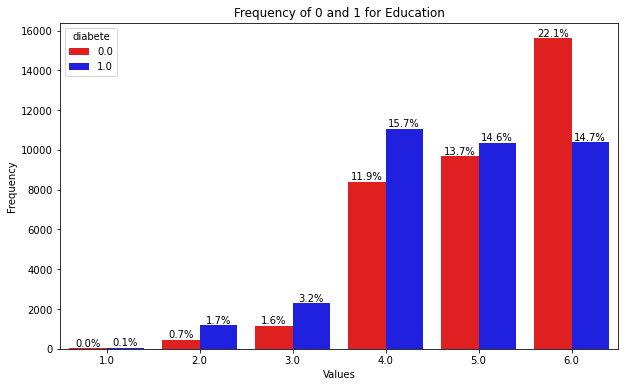

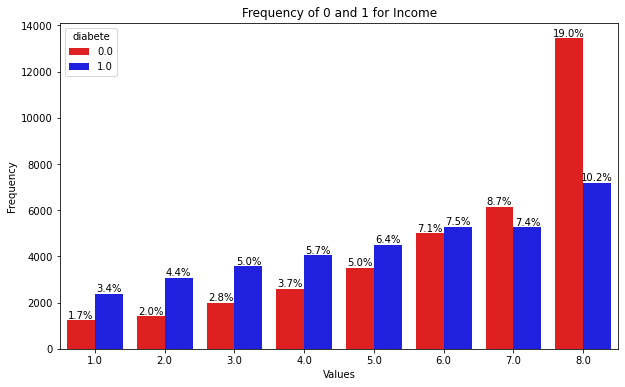

In [7]:
# Create a DataFrame with categorical variables for people with and without diabetes
cat = data.drop(columns=['BMI', 'MentHlth', 'PhysHlth'])
nb_col = len(cat.columns)

# Create barplots for each variable
for i in range(nb_col - 1):  # -1 to avoid the column 'diabete'
    column_name = cat.columns[i]

    # Create a barplot using seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=column_name, hue='diabete', data=cat, dodge=True, palette={0: 'red', 1: 'blue'})
    plt.title(f"Frequency of 0 and 1 for {column_name}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")

    # Calculate percentage and add annotations
    total = len(cat)
    for p in ax.patches:
        height = p.get_height()
        percentage = '{:.1f}%'.format(100 * height / total)
        ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center", va="bottom", fontsize=10)

    plt.show()

These graphs are interesting because they show the proportion of people with diabetes according to different characteristics. For example, in the first graph, people with high blood pressure have more diabetes than those with low blood pressure. 

This kind of graph with the sum of the bars equal to 100 is relevant for a balanced dataset. If this wasn't the case, they should have been presented in a different form.

Next, we want to observe the distribution of values for the numerical variables.

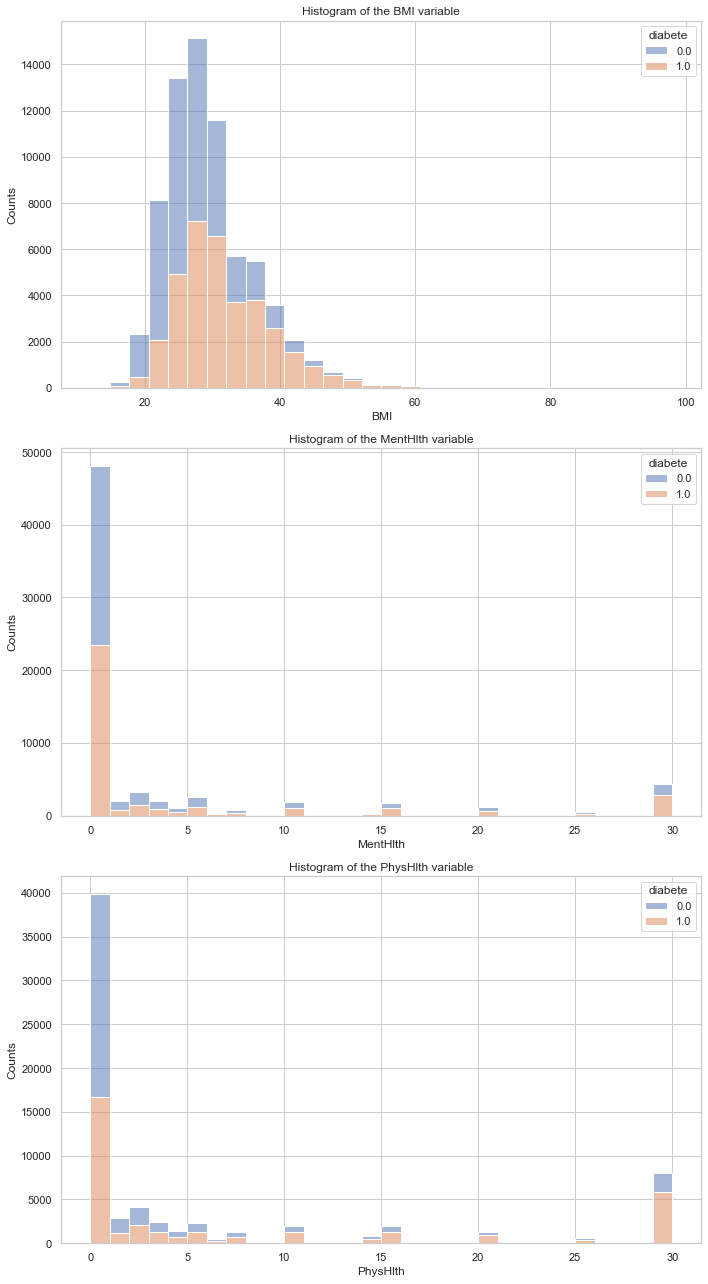

In [8]:
# Set the style
sns.set(style="whitegrid")

# Create subplots with Seaborn
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Plot BMI variable
sns.histplot(data=data, x='BMI', hue='diabete', multiple='stack', bins=30, alpha=0.5, ax=axes[0])
axes[0].set_title("Histogram of the BMI variable")
axes[0].set_xlabel("BMI")
axes[0].set_ylabel("Counts")

# Plot MentHlth variable
sns.histplot(data=data, x='MentHlth', hue='diabete', multiple='stack', bins=30, alpha=0.5, ax=axes[1], color='green')
axes[1].set_title("Histogram of the MentHlth variable")
axes[1].set_xlabel("MentHlth")
axes[1].set_ylabel("Counts")

# Plot PhysHlth variable
sns.histplot(data=data, x='PhysHlth', hue='diabete', multiple='stack', bins=30, alpha=0.5, ax=axes[2], color='orange')
axes[2].set_title("Histogram of the PhysHlth variable")
axes[2].set_xlabel("PhysHlth")
axes[2].set_ylabel("Counts")

# Show the plots
plt.tight_layout()
plt.show()

In order to use our models correctly, we transform all categorical variables into categories.

In [9]:
columns_to_convert = data.columns.difference(['BMI', 'MentHlth', 'PhysHlth'])

# Convertir les colonnes sélectionnées en catégories
data[columns_to_convert] = data[columns_to_convert].astype('category')

In [10]:
data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabete
0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0,0.0
1,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0,0.0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0,0.0
3,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0,0.0
4,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0,0.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   HighBP                70692 non-null  category
 1   HighChol              70692 non-null  category
 2   CholCheck             70692 non-null  category
 3   BMI                   70692 non-null  float64 
 4   Smoker                70692 non-null  category
 5   Stroke                70692 non-null  category
 6   HeartDiseaseorAttack  70692 non-null  category
 7   PhysActivity          70692 non-null  category
 8   Fruits                70692 non-null  category
 9   Veggies               70692 non-null  category
 10  HvyAlcoholConsump     70692 non-null  category
 11  AnyHealthcare         70692 non-null  category
 12  NoDocbcCost           70692 non-null  category
 13  GenHlth               70692 non-null  category
 14  MentHlth              70692 non-null  float64 
 15  Ph

### Correlation 

In [12]:
categorical_data = data.select_dtypes(include=['object', 'category'])


Now we want to see the correlations between the categorical variables.

In [13]:
# Create a function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

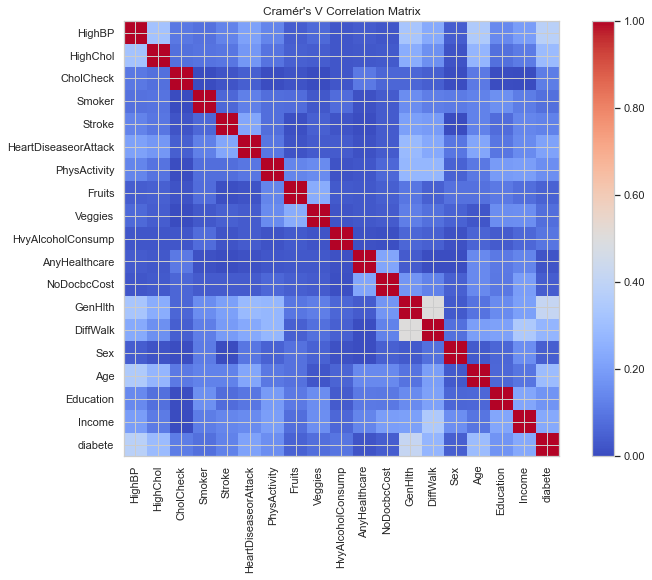

In [14]:
 # Create a DataFrame to store Cramér's V values
columns = categorical_data.columns
cramers_matrix = pd.DataFrame(index=columns, columns=columns)

# Calculate Cramér's V for each pair of categorical variables
for i in range(len(columns)):
    for j in range(len(columns)):
        if i == j:
            cramers_matrix.iloc[i, j] = 1.0
        else:
            cramers_matrix.iloc[i, j] = cramers_v(categorical_data[columns[i]], categorical_data[columns[j]])

# Convert the matrix to numeric, replacing non-numeric values with NaN
cramers_matrix = cramers_matrix.apply(pd.to_numeric, errors='coerce')

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(cramers_matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=1)  # set vmin and vmax based on your data
plt.colorbar(format='%.2f')
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns)
plt.title("Cramér's V Correlation Matrix")
plt.show()

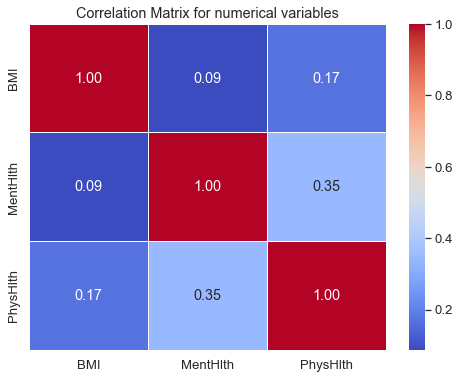

In [15]:
a = data[["BMI", "MentHlth", "PhysHlth"]].copy()

# Correlation Spearman matrix
cor_mat_spearman = a.corr(method='spearman')


# Display matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cor_mat_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix for numerical variables")
plt.show()

These two correlation matrices show that the variables are not correlated with each other. This means we don't need to delete any variables, as none of them are redundant.

## Creation of training and test samples.

To train my models, I decided to separate my database into a training set (80% of the data) and a test set (20% of the data). 

In [16]:
X = data.drop('diabete', axis=1)
y = data['diabete']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
y_train

C:\Users\elsad\anaconda3\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


61789    1.0
46280    1.0
18465    0.0
45540    1.0
28119    0.0
        ... 
37194    1.0
6265     0.0
54886    1.0
860      0.0
15795    0.0
Name: diabete, Length: 56553, dtype: category
Categories (2, float64): [0.0, 1.0]

## Testing several models

We will now try out several quick-to-implement models to see which algorithm performs best on our database. To compare their performance, we'll compare their ROC AUC score. I chose this AUC ROC score because it measures the performance of classification models. The ROC curve evaluates a model's overall performance across the entire spectrum of classification thresholds, providing an overview of the model's ability to discriminate between classes. The ROC curve and the AUC-ROC allow us to effectively compare the performance of different models. A model with a higher AUC-ROC is generally considered better in terms of its ability to discriminate between classes.

For each algorithm we will proceed as follows: 
- Model initialization
- Training the model on our training set
- Prediction on the test set
- Evaluation of model performance

### Logistic regression model

In [19]:
start_time = time.time()

# Initialize the logistic regression model
model = LogisticRegression(random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the total duration
training_time = end_time - start_time

# Predict on the test set
y_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]


# Calculate the ROC AUC on the test set
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC AUC:", roc_auc)
print(f"The model was trained in {training_time} seconds.")

ROC AUC: 0.8174595782374476
The model was trained in 0.5921709537506104 seconds.


C:\Users\elsad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNN model

In [32]:
start_time = time.time()

model = KNeighborsClassifier() # default number of neighbors = 5

# Train the model on the training set
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the total duration
training_time = end_time - start_time


# Predict on the test set
y_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]


# Calculate the ROC AUC on the test set
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC AUC:", roc_auc)
print(f"The model was trained in {training_time} seconds.")

ROC AUC: 0.7644097403206769
The model was trained in 0.018992900848388672 seconds.


### Random Forest model

In [40]:
start_time = time.time()

model = RandomForestClassifier(n_estimators=100, max_depth = 5, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the total duration
training_time = end_time - start_time


# Predict on the test set
y_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]


# Calculate the ROC AUC on the test set
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC AUC:", roc_auc)
print(f"The model was trained in {training_time} seconds.")

ROC AUC: 0.8180035239921396
The model was trained in 2.0975284576416016 seconds.


### SVM

I tried to do a SVM model but it took to long so I decided not to take it acount.

### XGBClassifier

In [76]:
# Use one-hot encoding for categorical variables
df_encoded = pd.get_dummies(data, columns=['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                                         'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
                                         'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income'])

# Define features (X) and target variable (y)
X = df_encoded.drop('diabete', axis=1)
y = df_encoded['diabete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start_time = time.time()

# Create XGBoost classifier
model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the total duration
training_time = end_time - start_time

# Predict probabilities on the test set
y_probabilities = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_probabilities)
print(f"ROC AUC Score: {roc_auc}")
print(f"The model was trained in {training_time} seconds.")

ROC AUC Score: 0.8243072920345412
The model was trained in 0.782508373260498 seconds.


At first glance, the XGBClassifier model seems to be the most appropriate for our dataset, as it has the highest ROC AUC. But the Random Forest model is not far behind. So we're going to work a little harder on these models.

## Choice of the hyperparameters

The aim of this part is now to choose the best hyperparameters to further improve our models. To do this, I tested several hyperparameters with the "GridSearchCV" function, which brings out the best parameters. Here I tested the different hyperparameters for Random forest and XGBClassifier to see if XGBClassifier was still the best of the models, as their scores were quite close.

### Random Forest

In [34]:
X = data.drop('diabete', axis=1)
y = data['diabete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [200,250,300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [10, 13, 15],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)

# Use GridSearchCV to test different hyperparameter combinations
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model configuration
best_rf_model = grid_search.best_estimator_

# Predict probabilities on the test set
probabilities = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC on the test set
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC AUC:", roc_auc)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 300}
ROC AUC: 0.8279357313634299


### XGBoost

In [54]:
# Define features (X) and target variable (y)
X = df_encoded.drop('diabete', axis=1)
y = df_encoded['diabete']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(XGBClassifier(objective='binary:logistic', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model configuration
best_rf_model = grid_search.best_estimator_

# Predict probabilities on the test set
probabilities = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC on the test set
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC AUC:", roc_auc)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
ROC AUC: 0.8315537059643547


In the XGBoost model the hyperparameters considered are :
- n_estimators : The number of boosting rounds or trees to build. A higher number can lead to better performance, but it also increases computation time.
- max_depth : It limits the number of nodes in the tree. Deeper trees can model more complex relationships but are prone to overfitting.
- Learning Rate : It controls the contribution of each tree to the final prediction.


## Choice of the final model : XGBoost

With the best parameters optimized, I found that the XGBoost was still the best model. Moreover, the model is very fast to run. So here's the final model:

In [55]:
start_time = time.time()

# Create XGBoost classifier
model = XGBClassifier(objective='binary:logistic',learning_rate= 0.1, max_depth = 3, n_estimators = 300, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the total duration
training_time = end_time - start_time

# Predict probabilities on the test set
probabilities = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, probabilities)
print(f"ROC AUC Score: {roc_auc}")
print(f"The model was trained in {training_time} seconds.")

ROC AUC Score: 0.8315537059643547
The model was trained in 1.5008721351623535 seconds.


This displays the ROC AUC curve.

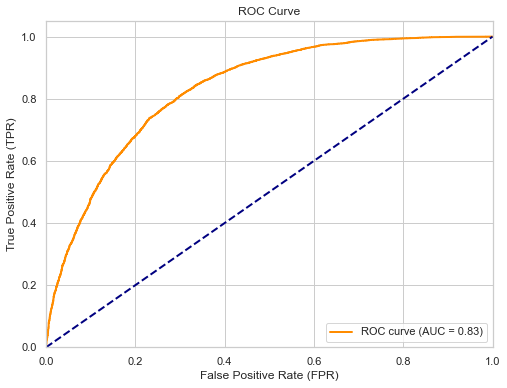

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

To analyze the curve correctly, we need to remember the following information : 

- An ideal model would have a True Positive Rate of 1 and a False Positive Rate of 0, meaning that it perfectly classifies all positive examples without making errors on negative ones. In this case, the ROC curve would pass through the top left-hand corner of the graph.


- The value of the ROC score of a random model (which predicts at random) is 0.5. The better a model is, the closer the score is to 1. 


0.83 is therefore considered a pretty good score but of course, there's still room for improvement.


## Conclusion

In conclusion, it was a database that was easy to handle without cleaning. Following the various model tests, XGBoost was the most relevant choice, and various tests enabled us to find its best parameters. The final score for this model is around 0.83.

Even if the score is quite satisfactory, it could still be improved. Indeed, it would have been interesting to test other hyperparameters in the KGBoost model, but also in other models such as KNN (number of neighbors, for example). With a little more time and power, we could also have tested other models such as SVM, which requires a very long execution time in our case. Finally, it would also have been interesting to use cross-validation to further optimize our models. 